<a href="https://colab.research.google.com/github/Elise643/AdvCS/blob/main/Unit%207/Unit_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unit 7 Project
For this unit, I found a data set in one of the provided links that included information on fall height vs. fall severity. I thought this sounded interesting enough and it looked like good data so I'm aiming to predict fall severity based on the height of the fall.

In [ ]:
!pip install preliz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 7.6 MB/s eta 0:00:00


In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import seaborn as sns
from sklearn import tree

In [ ]:
!pip install pymc-bart
import pymc_bart as pmb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 80.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.28.3
    Uninstalling pytensor-2.28.3:
      Successfully uninstalled pytensor-2.28.3
  Attempting uninstall: pymc
    Found existing installation: pymc 5.21.1
    Uninstalling pymc-5.21.1:
      Successfully uninstalled pymc-5.21.1


Here's my data. It was gathered in Singapore and is based on 416 fatal falls in 1991-1992. The fall height is a range in meters, corresponding in the following way
<br>
1&emsp;&emsp;&emsp;&emsp; 3m-10m<br>
2&emsp;&emsp;&emsp;&emsp; 10m-20m<br>
3&emsp;&emsp;&emsp;&emsp; 20m-30m<br>
4&emsp;&emsp;&emsp;&emsp; 30m-40m<br>
5&emsp;&emsp;&emsp;&emsp; 40m-50m<br>
6&emsp;&emsp;&emsp;&emsp; 50m-60m<br>
7&emsp;&emsp;&emsp;&emsp; 60m-70m<br>

Similarly, the severity is divided into groups. (The severity comes from the Injury Severity Score (ISS))<br>

1&emsp;&emsp;&emsp;&emsp; 1-14<br>
2&emsp;&emsp;&emsp;&emsp; 16-26<br>
3&emsp;&emsp;&emsp;&emsp; 27-36<br>
4&emsp;&emsp;&emsp;&emsp; 38-48<br>
5&emsp;&emsp;&emsp;&emsp; 50-59<br>
6&emsp;&emsp;&emsp;&emsp; 66-75<br>
<hr>
<footer>
(The source listed on the users.stat.ufl.edu page):<br>
Source: G. Lau, P.L. Ooi, and B. Phoon (1998). "Fatal Falls From a Height:
The Use of Mathematical Models to Estimate the Height of a Fall from the
Injuries Sustained," Forensic Science International, Vol. 93 pp. 33-34.
</footer>

In [ ]:
falls = pd.read_csv("https://users.stat.ufl.edu/~winner/data/singapore_falls.dat", header=None, sep='\s+')
falls.columns = ["Severity", "Height", "Count"]
falls

,Severity,Height,Count
0,1,1,1
1,2,1,9
2,3,1,7
3,4,1,5
4,5,1,6
5,6,1,4
6,1,2,1
7,2,2,8
8,3,2,12
9,4,2,18


The data is set up in such a way that rather than have a separate row for every recorded fall, they simply list all combinations of height and severity and mark how many falls fit that.

That was inconvenient for me, and I didn't like how many zeroes there were, so I reformatted it into a new dataframe (where yes, there is a Count column nevertheless, but I added that later and hadn't planned on it when I was doing this) where instead of labelling each combination with how many there were, I just had it list, for example, ten separate rows where the fall height is 7 and the severity score is 6.

In [ ]:
import pandas as pd

data = pd.DataFrame(columns=["Severity", "Height", "Count"])

for index, row in falls.iterrows():
    for i in range(row["Count"]):
        data = pd.concat([data, pd.DataFrame({"Severity": [row["Severity"]], "Height": [row["Height"]], "Count":[row["Count"]]})], ignore_index=True)

data


,Severity,Height,Count
0,1,1,1
1,2,1,9
2,2,1,9
3,2,1,9
4,2,1,9
...,...,...,...
411,6,7,10
412,6,7,10
413,6,7,10
414,6,7,10


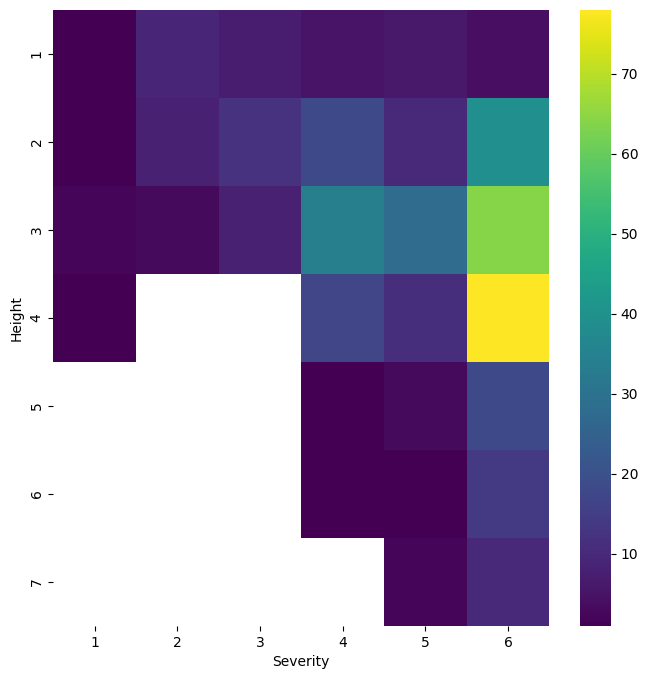

In [ ]:
# @title Severity vs Height

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Height'].value_counts()
    for x_label, grp in data.groupby('Severity')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Severity')
_ = plt.ylabel('Height')

Better representation of the data, yay! The darker shades have less falls and the lighter have more. (Very high data concentration at fall height 4, severity 6)

I tried to find a color palette that would make it easier to see the more subtle differences, but this ended up being the one I preferred.

In [ ]:
X = data["Height"].to_numpy().reshape(-1, 1)
Y = data["Severity"].to_numpy().reshape(-1, 1)
Count = ((np.array(data['Count'], dtype=np.float32)+70)/3+30)

In [ ]:
dtree = tree.DecisionTreeRegressor(max_depth=7)
falltree = dtree.fit(X,Y)
y = falltree.predict(X)

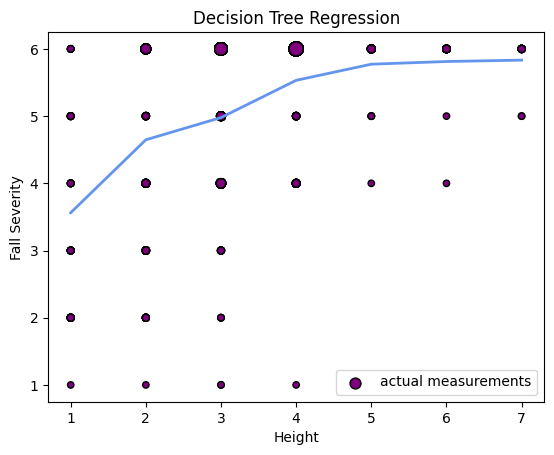

In [ ]:
plt.figure()
plt.scatter(X, Y, s=((Count/25)**4),edgecolor="black", c="purple", label="actual measurements")
plt.plot(X, y, color="cornflowerblue", linewidth=2)
plt.xlabel("Height")
plt.ylabel("Fall Severity")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

I wanted a way to better represent the data in comparison to the BART prediction, so this is what I ended up with. The bigger dots have a higher concentration, so you can see that 4,6 is still the largest. I tried to give it a stronger variance in size, but anything I tried made the smaller values too small or the larger ones too big. This version divides the count by 25 and then raises it to the power of four (squared twice? I don't think there's an easy way to say it like squared or cubed).